In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def parse_contribution_tree(scenario):
    # Read the Excel file into a DataFrame
    df = pd.read_excel('contribution_tree.xlsx', 'Upstream tree')

    # Get the impact category and unit as the dataset name
    labels = df.columns[0].split(':')
    category = ','.join(labels[1:])[1:]
    unit = df.iloc[0][8]
    unit = unit[unit.find('[')+1:unit.find(']')]
    unit = ''.join(['[', unit, ']'])
    name = ''.join([category, ' ', unit])

    # Initialize variables
    processes = []
    final_rows = []
    current_subprocess_level = -1

    # Iterate through the rows of the dataframe
    for i, row in df.iterrows():
        # Replace nan by 0 in 'Direct contributions [CTUe]' column
        if pd.isna(row.iloc[-1]):
            row.iloc[-1] = 0

        # Determine level by checking which cell is filled in the row
        level = next((j for j in range(len(row)) if not pd.isna(row[j])), len(row))
        if level == current_subprocess_level:
            current_subprocess_level -= 1

        # Check if the current row is a subprocess
        if row[level].startswith(scenario):
            current_subprocess_level = level
            row['Level'] = level
            final_rows.append(row.dropna().values)
            processes.append([row.dropna().values])

        # Check if the row is an activity and needs to be retained
        elif not pd.isna(row[level]):
            # Check if the activity is directly under a subprocess
            if level - 1 == current_subprocess_level:
                # Direct child of a subprocess
                row['Level'] = level
                final_rows.append(row.dropna().values)

    # Create a new DataFrame from the filtered rows
    final_rows[0][-1] = 'Level'
    final_df = pd.DataFrame(final_rows)
    final_df.columns = final_df.iloc[0]
    final_df = final_df[1:]

    # Group subprocesses
    for i, row in final_df.iterrows():
        for j, p in enumerate(processes):
            if row['Level'] - 1 == p[0][-1]:
                p.append(row.values)

    final_processes = []
    for i, p in enumerate(processes):
        final_processes.append(pd.DataFrame(list(map(np.ravel, p)), columns=final_df.columns))
    
    return name, final_df, final_processes

In [4]:
category, contributions, processes = parse_contribution_tree('Baseline')

c:\Users\OMISTAJA\Anaconda\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_8072\888769057.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  unit = df.iloc[0][8]
C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_8072\888769057.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  level = next((j for j in range(len(row)) if not pd.isna(row[j])), len(row))
C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_8072\888769057.py:30: Futu

In [5]:
category

'Human toxicity, carcinogenic, inorganics [CTUh]'

In [6]:
processes[0]

,Processes,Result [CTUh],Direct contribution [CTUh],Level
0,"Baseline - 7 Effluent treatment, substitution ...",-8.985897e-06,0.000000e+00,0
1,"market for hazardous waste, for underground de...",2.368781e-08,0.000000e+00,1
2,"market group for electricity, medium voltage |...",1.849581e-08,0.000000e+00,1
3,"market for wastewater, average | wastewater, a...",1.199468e-09,3.737418e-11,1
4,"market for quicklime, milled, packed | quickli...",9.353848e-10,0.000000e+00,1
5,market group for tap water | tap water | Cutof...,3.306377e-10,0.000000e+00,1
6,"market for wastewater, unpolluted | wastewater...",2.983697e-10,0.000000e+00,1
7,"Baseline - 6 Li recovery, substitution - RER",-9.030844e-06,0.000000e+00,1


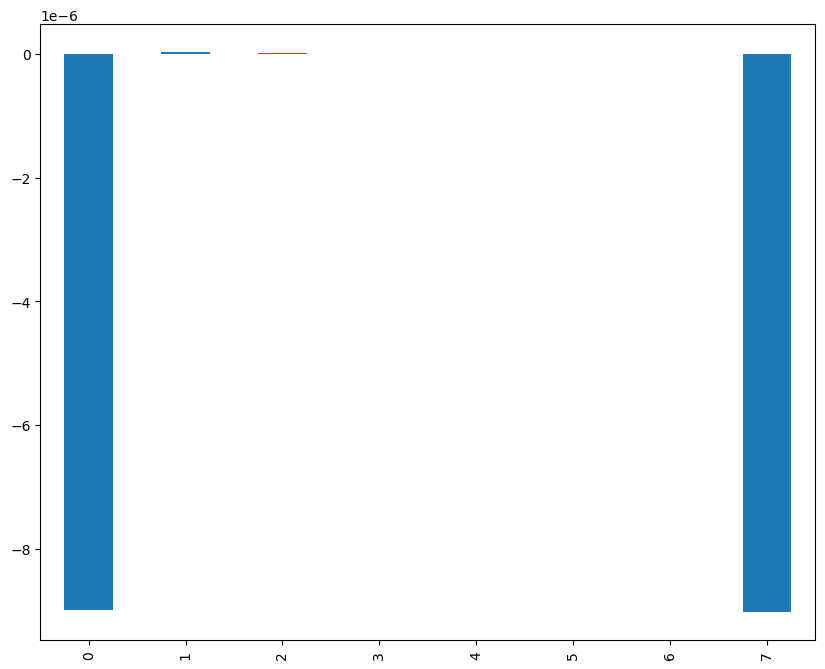

In [32]:
res = processes[0].columns.values[1]

fig, ax = plt.subplots(figsize=(10, 8))
processes[0][res].plot.bar(ax=ax, stacked=True)
plt.show()